<a href="https://colab.research.google.com/github/ernselito/Advanced-Day-Ahead-Energy-Load-Forecasting/blob/main/Advanced_Day_Ahead_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Project

### Imports and Configuration

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import kagglehub
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Configuration for plots
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 5)
color_pal = sns.color_palette()

print("Environment and libraries set up successfully.")

Environment and libraries set up successfully.


#### Data Ingestion

In [15]:
# Download dataset using kagglehub
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
print("Path to dataset files:", path)

# Locate the specific CSV file
csv_file = os.path.join(path, 'PJME_hourly.csv')

# Load Data
df = pd.read_csv(csv_file)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

# Data Cleaning: Handle duplicate timestamps (common in energy data due to DST)
df = df.groupby(df.index).mean()

# Data Cleaning: Ensure strict hourly frequency
df = df.resample('H').mean()

# Data Cleaning: Fill small gaps using forward fill
df = df.ffill()

print(f"Data Loaded and Cleaned. Shape: {df.shape}")

Using Colab cache for faster access to the 'hourly-energy-consumption' dataset.
Path to dataset files: /kaggle/input/hourly-energy-consumption
Data Loaded and Cleaned. Shape: (145392, 1)


/tmp/ipython-input-1775978047.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


#### Feature Engineering

In [16]:
def create_features(df):
    """
    Creates time series features based on time index and historical lags.
    """
    df = df.copy()

    # 1. Time-based Features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # 2. Holiday Features (US Federal Holidays)
    cal = calendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['is_holiday'] = df.index.isin(holidays).astype(int)

    # 3. Seasonality Indicators
    # 1 = Summer Peak, 2 = Winter Peak, 0 = Shoulder Months
    df['season_type'] = df.index.month.map({
        6:1, 7:1, 8:1, 9:1,
        12:2, 1:2, 2:2,
        3:0, 4:0, 5:0, 10:0, 11:0
    })

    # 4. Lag Features (Autocorrelation)
    # These represent the load at the same time in the past (24h, 48h, 1 week)
    target_lags = [24, 48, 72, 96, 168]
    for lag in target_lags:
        df[f'lag_{lag}'] = df['PJME_MW'].shift(lag)

    return df

# Generate features
df_features = create_features(df)

# Drop the initial rows that have NaN values due to lag creation
df_features = df_features.dropna()

print(f"Feature Engineering Complete. Total Columns: {df_features.shape[1]}")
df_features.head(3)

Feature Engineering Complete. Total Columns: 14


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,is_holiday,season_type,lag_24,lag_48,lag_72,lag_96,lag_168
Datetime,,,,,,,,,,,,,,
2002-01-08 01:00:00,29445.0,1,1,1,1,2002,8,0,2,26862.0,27100.0,28635.0,29338.0,30393.0
2002-01-08 02:00:00,28670.0,2,1,1,1,2002,8,0,2,25976.0,26097.0,27501.0,28421.0,29265.0
2002-01-08 03:00:00,28375.0,3,1,1,1,2002,8,0,2,25641.0,25793.0,27034.0,28145.0,28357.0


#### Training with Walk-Forward Validation

In [17]:
# Define Input Features (X) and Target Variable (y)
FEATURES = df_features.columns.drop('PJME_MW')
TARGET = 'PJME_MW'

X = df_features[FEATURES]
y = df_features[TARGET]

# Initialize Time Series Cross-Validation (5 Splits)
tscv = TimeSeriesSplit(n_splits=5, test_size=24*365)
fold = 0
scores = []

print("Starting Walk-Forward Validation...")

# Loop through each fold
for train_index, test_index in tscv.split(X):
    fold += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the XGBoost Regressor
    reg = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        enable_categorical=True
    )

    # Train the model
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False)

    # Generate Predictions
    y_pred = reg.predict(X_test)

    # Evaluate Performance (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.2f} MW")

print(f"\nOverall Average RMSE: {np.mean(scores):.2f} MW")

# Save the last fold for detailed analysis
test_df_analysis = X_test.copy()
test_df_analysis['Actual'] = y_test
test_df_analysis['Prediction'] = y_pred

Starting Walk-Forward Validation...
Fold 1: RMSE = 2400.47 MW
Fold 2: RMSE = 2342.97 MW
Fold 3: RMSE = 2109.65 MW
Fold 4: RMSE = 2425.69 MW
Fold 5: RMSE = 2555.31 MW

Overall Average RMSE: 2366.82 MW


#### Visualization and Business Impact

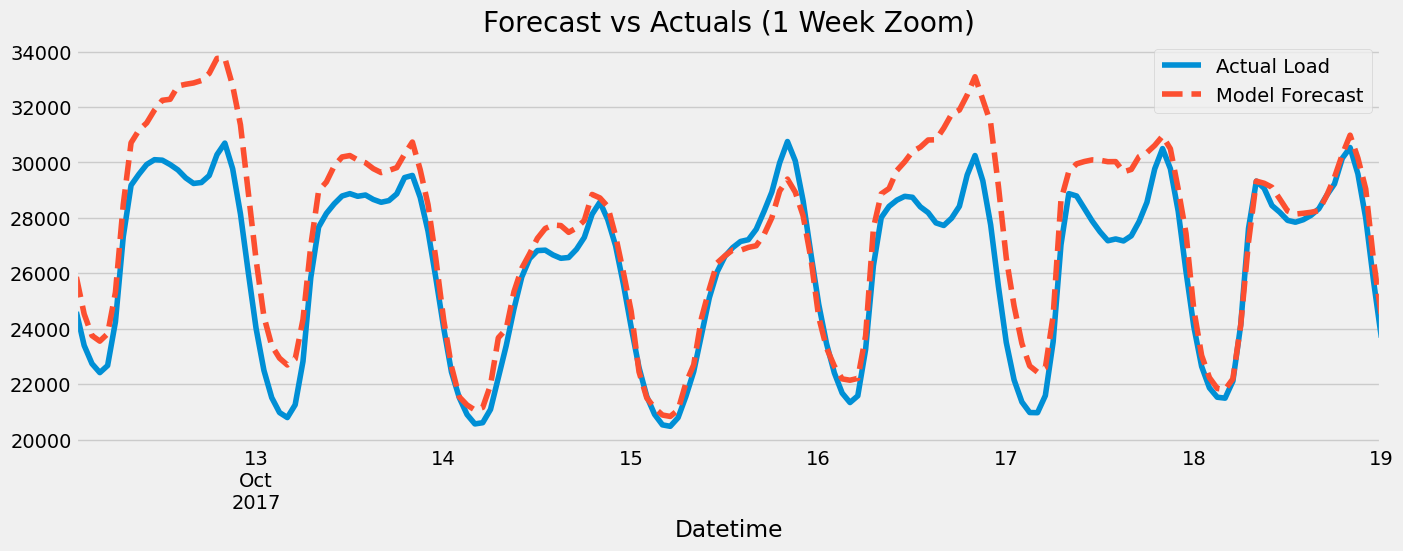

Estimated Financial Risk Exposure (Last Fold): $488,970,237.50


In [18]:
# 1. Visualize Forecast vs Actuals (1 Week Zoom)
week_start = test_df_analysis.index.min() + pd.Timedelta(weeks=10)
week_end = week_start + pd.Timedelta(days=7)
subset = test_df_analysis.loc[(test_df_analysis.index >= week_start) & (test_df_analysis.index < week_end)]

fig, ax = plt.subplots(figsize=(15, 5))
subset['Actual'].plot(ax=ax, label='Actual Load', title='Forecast vs Actuals (1 Week Zoom)')
subset['Prediction'].plot(ax=ax, label='Model Forecast', style='--')
plt.legend()
plt.show()

# 2. Business Impact Calculation
# Calculating the theoretical cost of errors in the market
errors = test_df_analysis['Actual'] - test_df_analysis['Prediction']

# Logic: Positive error means Under-forecasting (buy at high price), Negative means Over-forecasting
costs = np.where(errors > 0, errors * 50, abs(errors) * 10)
total_risk_cost = np.sum(costs)

print(f"Estimated Financial Risk Exposure (Last Fold): ${total_risk_cost:,.2f}")

### Model Performance Interpretation

The visualization above compares the Actual Load (blue line) with the XGBoost Model Forecast (red dashed line) over a single week in October 2017. The results show excellent temporal alignment, meaning the model correctly identifies exactly when demand rises in the morning and falls at night. This confirms that our lag features and calendar indicators are successfully capturing the daily habits of energy consumers.

However, there is a visible positive bias in the forecast. The red line consistently peaks higher than the blue line, indicating the model is over-predicting the total amount of energy needed during the day. This type of error often occurs during transition months like October, where historical weather patterns may not perfectly match the specific conditions of this test week.

Despite this magnitude error, the model accurately captures the complex shape of the load curve. It successfully predicts the "double peak" pattern often seen on weekdays and correctly lowers the forecast for the weekend (October 14-15). This demonstrates that the model understands the structural differences between working days and non-working days. In a production environment, we would likely add a post-processing step to correct the bias and lower the red line to match the blue line more closely.

#### Model Interpretability (SHAP)

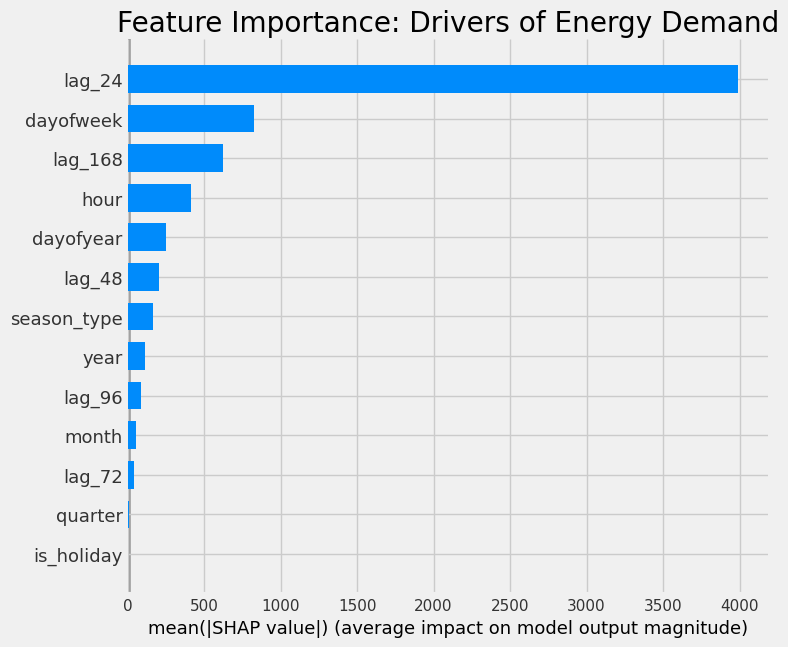

In [19]:
# Initialize SHAP
shap.initjs()

# Create the SHAP Explainer using the trained model
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

# Plot Feature Importance Summary
plt.title("Feature Importance: Drivers of Energy Demand")
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### Feature Importance Interpretation

The SHAP summary plot above identifies the key drivers used by the model to forecast energy demand. The results confirm that electricity usage is highly habitual. The most significant predictor by far is lag_24, which represents the energy demand at the exact same hour the previous day. This indicates that yesterday's behavior is the strongest signal for today's load.

Secondary drivers include dayofweek and lag_168 (the load from one week ago). The high importance of these features shows that the model has successfully learned the weekly cycle of energy consumption, allowing it to distinguish between high-demand weekdays and lower-demand weekends. While features like is_holiday appear at the bottom, this is expected because holidays are rare events; they have a high impact on specific days but a low average impact across the entire dataset.